# 随机森林实例

## 1. 填补缺失值

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score

In [3]:
housing = fetch_california_housing()

In [8]:
housing.target
housing.data.shape

(20640, 8)

In [6]:
from sklearn.datasets import load_boston

In [7]:
boston = load_boston()

c:\myprogram\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.


In [9]:
boston.data.shape

(506, 13)

**构造缺失数据**

In [10]:
x_full, y_full = boston.data, boston.target

In [11]:
n_samples = boston.data.shape[0]
n_features = boston.data.shape[1]

In [12]:
rng = np.random.RandomState(0)
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))

In [13]:
missing_features = rng.randint(0, n_features, n_missing_samples)
missing_samples = rng.randint(0, n_samples, n_missing_samples)

In [15]:
missing_features.shape

(3289,)

In [16]:
x_missing = x_full.copy()
y_missing = y_full.copy()
x_missing[missing_samples, missing_features] = np.nan

In [17]:
x_missing

array([[       nan, 1.8000e+01,        nan, ...,        nan,        nan,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00,        nan, ...,        nan, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02,        nan, 7.0700e+00, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan, 1.1930e+01, ..., 2.1000e+01,        nan,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ...,        nan, 3.9690e+02,
        7.8800e+00]])

In [18]:
x_missing = pd.DataFrame(x_missing)

In [19]:
x_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


**利用固定值和均值填补缺失值**

In [23]:
# 利用均值进行填补
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
x_missing_mean = imp_mean.fit_transform(x_missing)

# 利用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
x_missing_0 = imp_0.fit_transform(x_missing)

In [25]:
pd.DataFrame(x_missing_mean).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

**利用随机森林填补缺失值**

通常情况下，不会采用算法来填补缺失值，但是在用固定值、均值填充都不合适的情况下，可以考虑用算法进行填充

对于一个有n个特征的数据来说，其中**一列特征T有缺失**，可以将其他n-1个特征和目标值作为新的特征，将特征T作为我们预测的目标。其中特征T中无缺失的部分作为y_train, 有缺失的部分作为y_test,是我们需要预测的部分

自然地我们会想到如果不止一个特征值有缺失，有**多个特征值列都有缺失的情况**呢？

答案是遍历所有的特征，先从缺失最少的开始进行填补(因为填补这一列需要的准确信息最少)。
在填补某一列时，先将其他列中的缺失值用0代替，每次回归得到该列的结果后，再将该列放回原本的特征矩阵中，在继续填充下一个特征。每次填补完毕，有缺失值的特征就会减少一个，所以需要用0填补的特征会越来越少。

In [35]:
x_missing_reg = x_missing.copy()
sortindex = np.argsort(x_missing_reg.isnull().sum(axis=0)).values  # 依次返回值所在位置的索引
for i in sortindex:
    
    # 构建新的特征和新的目标列
    df = x_missing_reg
    fillc = df.iloc[:, i]
    df = pd.concat([df.iloc[:, df.columns!=i], pd.DataFrame(y_full)], axis=1)
    
    # 新特征矩阵中，缺失值用0填充
    df_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    df_0 = df_0.fit_transform(df)
    
    # 找出训练集和测试集
    y_train = fillc[fillc.notnull()]
    y_test = fillc[fillc.isnull()]
    x_train = df_0[y_train.index, :]
    x_test = df_0[y_test.index, :]
    
    # 用随机森林填充缺失值
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(x_train, y_train)
    y_predict = rfc.predict(x_test)
    
    # 将填补好的特征返回到原始的特征矩阵中
    x_missing_reg.iloc[y_test.index, i] = y_predict
    

In [36]:
x_missing_reg.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

**对填补好的数据进行建模**

In [37]:
X = [x_full, x_missing_mean, x_missing_0, x_missing_reg]

mse = []
for x in X:
    estimator = RandomForestRegressor(n_estimators=100)
    scores = cross_val_score(estimator, x, y_full, scoring='neg_mean_squared_error', cv=5).mean()
    mse.append(scores*-1)


In [39]:
[*zip(['x_full', 'x_missing_mean', 'x_missing_0', 'x_missing_reg'], mse)]

[('x_full', 20.96150636192971),
 ('x_missing_mean', 40.84506547629584),
 ('x_missing_0', 48.24120658980779),
 ('x_missing_reg', 18.362818797185)]

**所得结果画出图形**

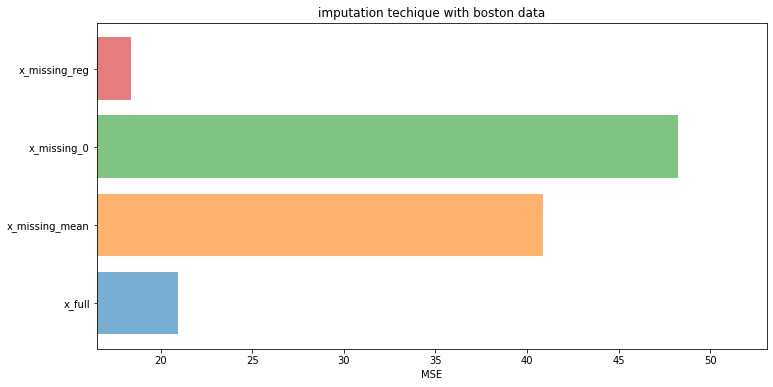

In [47]:
labels = ['x_full', 'x_missing_mean', 'x_missing_0', 'x_missing_reg']
colors = ['red', 'green', 'blue', 'orange']

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

for i in range(len(mse)):
    plt.barh(i, mse[i], alpha=0.6, align='center')
ax.set_title('imputation techique with boston data')
ax.set_xlim(left=0.9*min(mse), right=1.1*max(mse))
ax.set_xlabel('MSE')
ax.set_yticks(np.arange(len(mse)))
ax.set_yticklabels(labels)

plt.show()